In [387]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import math
from datetime import datetime
from sklearn import linear_model

data = pd.read_csv("owid-covid-data.csv") 

data = data[data.iso_code=="RUS"]
data = data[data.date >= '2020-03-03']
data.head(1000)

total = np.array(data.total_cases[0:50])

new = np.array(data.new_cases[0:50])
new = [x if x!=0 else 1 for x in new]


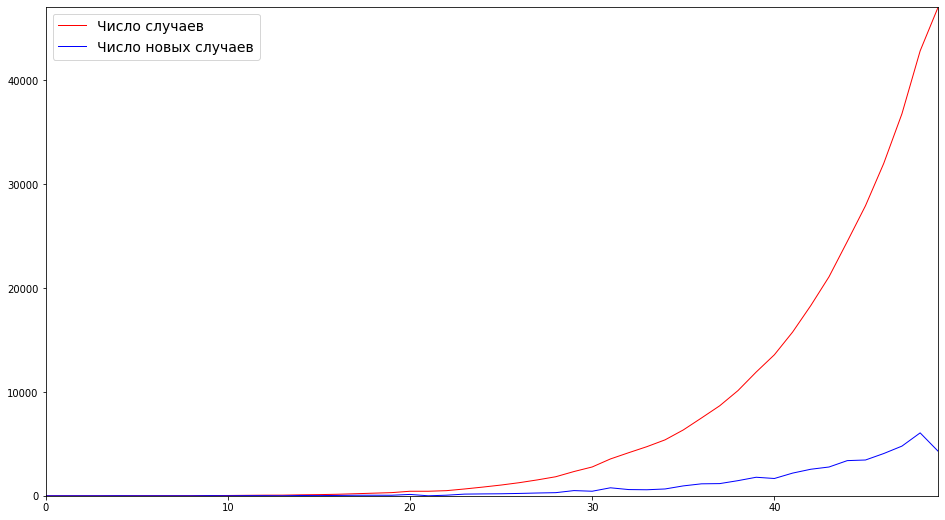

In [388]:
days = np.linspace(0,49,50)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlim((days[0], days[-1]))
ax.set_ylim((0, total[-1]))

ax.plot(days, total, linewidth=1, label="Число случаев", color="red")
ax.plot(days, new, linewidth=1, label="Число новых случаев", color="blue")

ax.legend(loc="upper left", fontsize=14)

plt.show()

Будем исходить из априорного распределения параметров y = exp{w0*x + w1} из N(0, a*I). Найдем параметры нормального апостериорного распределения p(w|D)

In [389]:
def create_X_matrix(n):
    t = range(0,2*n)
    t = np.array([ x/2 if x%2==0 else 1 for x in t])
    t= t.reshape(n,2)
    return t

In [390]:
import math

def param_function(a,b,d,N,X,y, S=None):
    if S is None:
        S = np.eye(d)
    A = b* (X.transpose()).dot(X) + S * a
    #print(A)
    m = b * np.linalg.inv(A).dot(X.transpose().dot(y))
    #print(m)
    return  .5 * d * math.log(a) \
            + .5*N * math.log(b) \
            - 0.5 * b * np.linalg.norm(y- X.dot(m)) ** 2  \
            - 0.5 * a * np.linalg.norm(m)**2 \
            - 0.5 * math.log(np.linalg.det(A)) 

Оптимизируем параметры a и b исходя из dataset числа заболевших

In [391]:
X = create_X_matrix(50)
total_exp = np.array([math.log(t) for t in total])

param_function(1,1,2,50,X,total_exp)

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,total_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)


0.934448160535117 7.443143812709029 16.52761391495929


Найтем математическое ожидание апостериорного распредерения, для этого надо использовать гребневую регрессию с регуляризатором a/b

In [392]:
from sklearn import linear_model

model = linear_model.Ridge(alpha = best_a/best_b, fit_intercept=False).fit(X, total_exp)

print("Среднее апостериорного распределения", model.coef_)

Среднее апостериорного распределения [0.2037106 1.4647382]


In [393]:
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Стандартное отклонение апостериорного распределения: 0.34549391102679233


Построим распределение прогноза числа заболевших на 3 даты

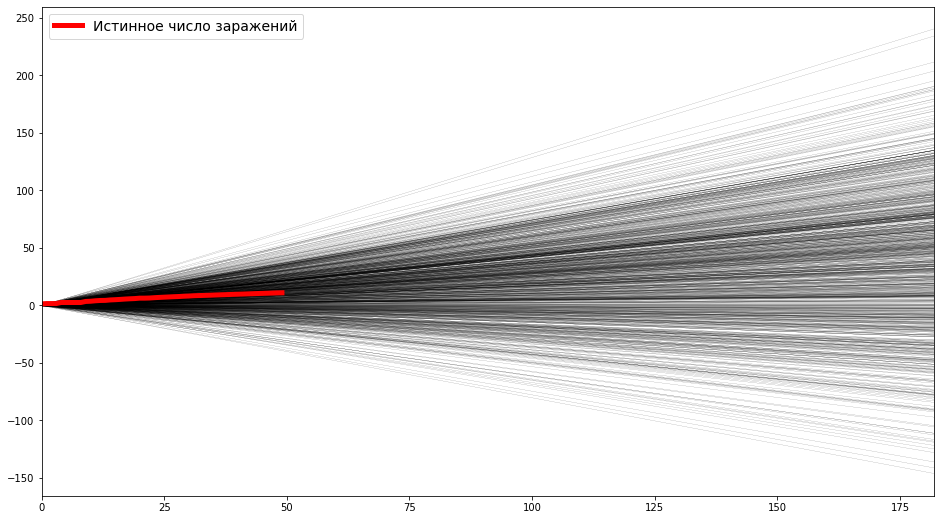

In [394]:
from scipy.stats import multivariate_normal
import datetime

mean = [model.coef_[0], model.intercept_]

def get_sample(mean, std_dev, n):
     return multivariate_normal.rvs(mean=mean, cov=np.eye(n)*std_dev**2)

days = np.linspace(0,100,101)


start = datetime.date(2020,3,3)
may_1 = (datetime.date(2020,5,1) - start).days
jun_1 = (datetime.date(2020,6,1) - start).days 
sep_1 = (datetime.date(2020,9,1) - start).days 

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))

for i in range(0,1000):
    sample = get_sample(mean, std_dev,2)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])

    
ax.plot(range(0,50), total_exp, linewidth=5, color="red", label = "Истинное число заражений")
ax.legend(loc="upper left", fontsize=14)
plt.show()


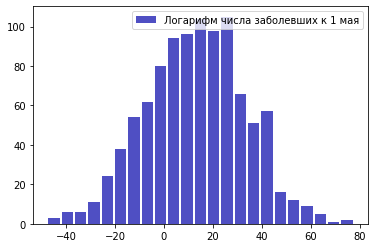

In [395]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 мая')
plt.legend()

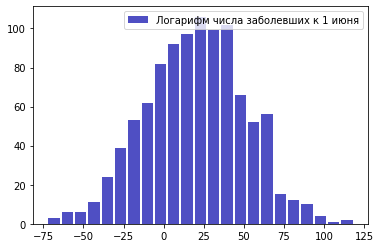

In [396]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 июня')
plt.legend()

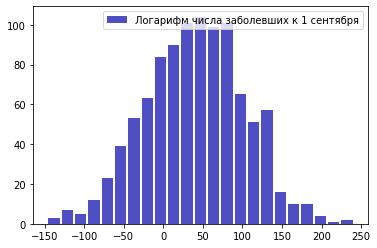

In [397]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 сентября')
plt.legend()

Сделаем то же самое для new_cases

In [398]:
X = create_X_matrix(50)
new_exp = np.array([math.log(t) for t in new])

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,new_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)

36.81571906354515 1.4351170568561873 -20.28557221197176


In [399]:
model = linear_model.Ridge(alpha = best_a/best_b, fit_intercept=False).fit(X, new_exp)

mean = model.coef_
print("Среднее апостериорного распределения", mean)
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Среднее апостериорного распределения [ 0.18959038 -0.017758  ]
Стандартное отклонение апостериорного распределения: 0.16168864949559822


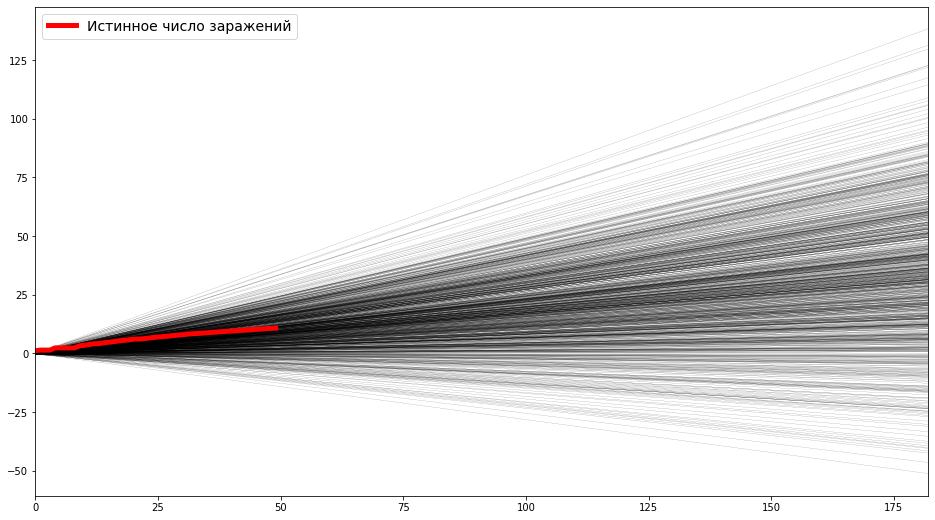

In [400]:
days = np.linspace(0,100,101)

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))



for i in range(0,1000):
    sample = get_sample(mean, std_dev,2)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])
    
    
ax.plot(range(0,50), total_exp, linewidth=5, color="red", label = "Истинное число заражений")

ax.legend(loc="upper left", fontsize=14)
plt.show()

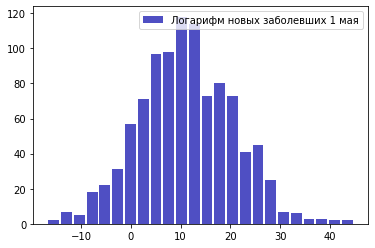

In [401]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 мая')
plt.legend()

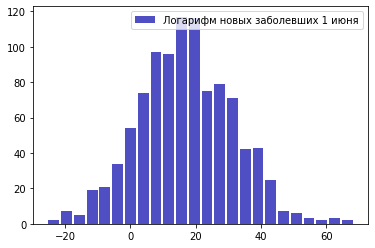

In [402]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 июня')
plt.legend()

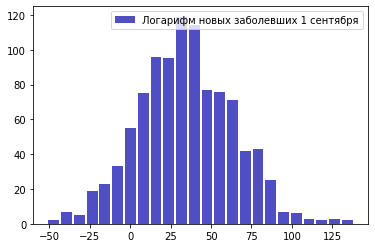

In [403]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 сентября')
plt.legend()

## 3.

 Для подбора сигмоиды перейдем от total_cases к new_cases, возьмем логорифм и будем приближать полученные значения регрессией. Действовать будем по аналогии с предыдущим пунктом. Кроме того, мы зафиксируем дисперсию при x^2 т.к. при "стандартном" подходе мы можем получить положительные значения при сэмплинге и тогда модель потеряет смысл

In [404]:
x0 = [1 for _ in range(0,50)]
x1 = [i for i in range(0,50)]
x2 = [i*i for i in range(0,50)]

X = np.vstack([x0,x1,x2]).transpose()
#print(X)
S = np.array([[1,0,0],[0,1,0],[0,0,0.0000001]])
result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,3,50,X,new_exp,S)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)

38.65150501672241 1.4351170568561873 -25.19556001355749


Среднее апостериорного распределения [-0.09781892  0.21580772 -0.00064154]
Стандартное отклонение апостериорного распределения (кроме коэффицента x^2): 0.15794295866242705


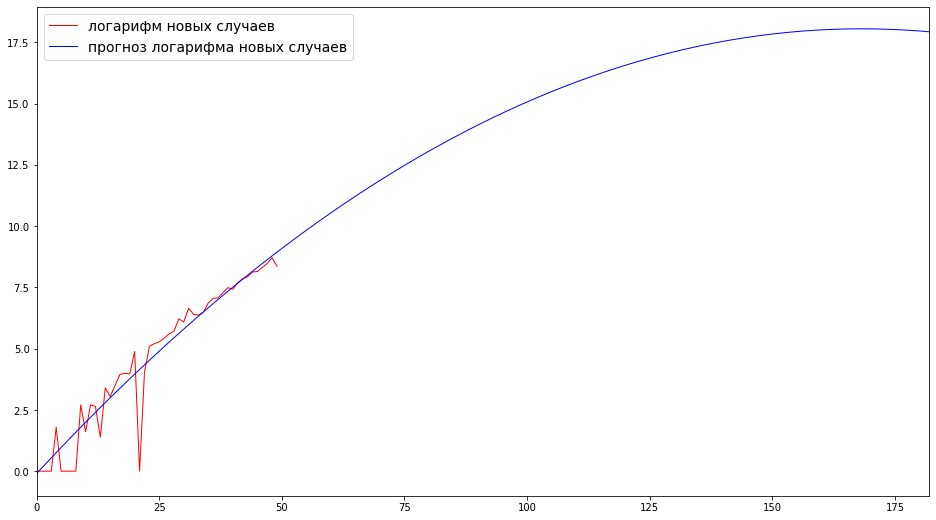

In [405]:
#print(new_exp)

model = linear_model.Ridge(alpha = best_a/best_b, fit_intercept = False).fit(X, new_exp)
mean = model.coef_
print("Среднее апостериорного распределения", mean)
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения (кроме коэффицента x^2):", std_dev)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlim((days[0], days[-1]))
forecast = [mean[0] + mean[1]*x + mean[2]*x**2 for x in days]

ax.plot(range(0,50), new_exp, linewidth=1, label="логарифм новых случаев", color="red")
ax.plot(days, forecast, linewidth=1, label="прогноз логарифма новых случаев", color="blue")

ax.legend(loc="upper left", fontsize=14)

plt.show()

In [406]:
def get_total_cases(p_x0, p_x1, p_x2, day):
    p_x2 = -p_x2
    p_x1 = -p_x1
    p_x0 = -p_x0
    
    #print("x2:", p_x2,"x1:", p_x1, "x0", p_x0)
    #print("новых", p_x0 + p_x1*day + p_x2*day**2)
    # замена переменных   
    y = day * math.sqrt(2*p_x2) + p_x1 / math.sqrt(2*p_x2)
    
    #print(p_x2, p_x1, p_x0)
    #print("было стало",day,y)
    
    #print(sp.stats.norm.cdf(y) * math.sqrt(math.pi/p_x2))
    #print(math.exp(p_x0 - .25*p_x1**2/p_x2))
    
    # максимальное число заболевших и прогноз общего числа больных на день day
    return [math.sqrt(math.pi/p_x2) * math.exp(-p_x0 + .25*p_x1**2/p_x2), \
            sp.stats.norm.cdf(y) * math.sqrt(math.pi/p_x2) * math.exp(-p_x0 + .25*p_x1**2/p_x2)]

[-0.09781892  0.21580772 -0.00064154]


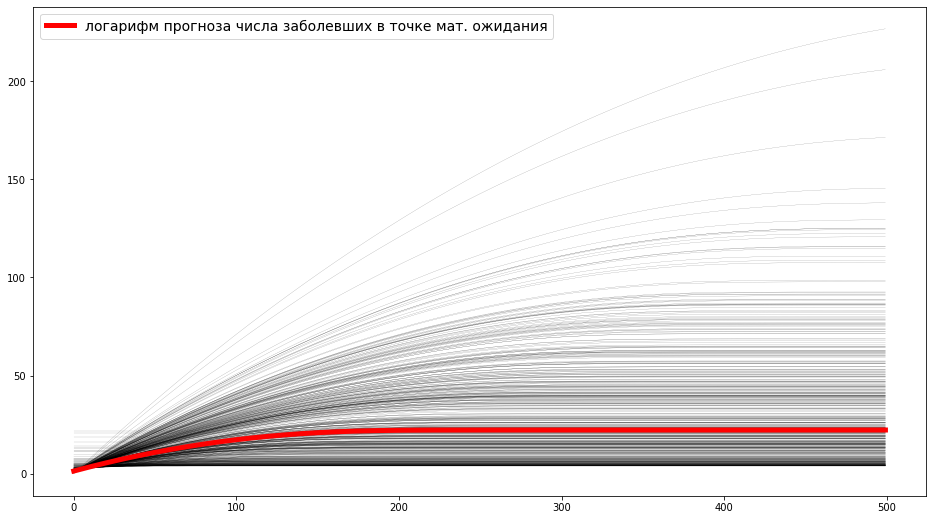

In [416]:
days = np.linspace(0,100,101)

print(mean)

total_cases = []

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

forecast = [math.log(get_total_cases(mean[0], mean[1], mean[2], x)[1]) for x in range(0,500)]

for i in range(0,500):
    sample = get_sample([mean[0],mean[1]], std_dev,2)
    total_cases.append(math.log(get_total_cases(sample[0], sample[1], mean[2], 0)[0]))
    generated = [math.log(get_total_cases(sample[0], sample[1], mean[2], x)[1]) for x in range(0,500)]    
    ax.plot(range(0,500), generated, linewidth=.1, color="black")
    

ax.plot(range(0,500), forecast, linewidth=5, color="red", label = "логарифм прогноза числа заболевших в точке мат. ожидания")    
ax.legend(loc="upper left", fontsize=14)
plt.show()


оптимистичный сценарий: 164.24725190403896 заболевших
пессимистичный сценарий: 8.826973244225181e+30 заболевших


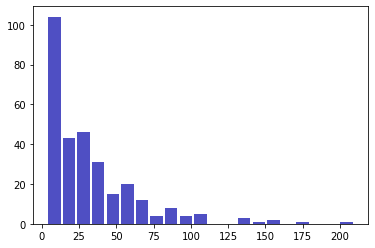

In [412]:
plt.hist(x=total_cases, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Прогноз логарифма общего числа заболевших')

total_cases.sort()
print("оптимистичный сценарий:", math.exp(total_cases[50]),"заболевших")
print("пессимистичный сценарий:", math.exp(total_cases[450]),"заболевших")

## 5

Довольно бессмысленно моделировать экспоненциальные ряды с помощью сигмоиды, пока распространение не начало замедляться, прогноз общего числа заболевших ничего не даст, т.к. слишком чувствителен. Насчет карантина, если бы сигмоида отработала, карантин бы повлиял на коэффиценты в экспоненте и на общее число зараженных, можно было бы оценить, как именно.